### Imports

In [1]:
Tf_Features = 10
One_Hot =  False
Standard_Scale = True
N_Gram = 1

In [2]:
def text_cleaner(text,all_stop):
    """
    clean_str = text_cleaner(dirty_string)
    """
    regex = re.compile('[%s]' % re.escape(string.punctuation))

    text = text.lower()
    text = text.replace('<!--DONOTREMOVEESSAYDIVIDER-->',' ')
    text = text.replace('\n' , ' ')
    text = regex.sub('',text)
    text = ' '.join([word for word in text.split() if word not in all_stop])
    return(text)

In [3]:
import gc
import re
import string
import calendar
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
donor_type = {'Unnamed: 0':int, 'Donor ID': str, 
    'Donor City': str, 'Donor State': str, 'Donor Is Teacher': str, 'Donor Zip': str, 'Donations Count': int,
    'Donation Mean Amount': float, 'Donation Sum Amount': float, 'Donation Median Amount': float,
    'Donation Max Amount': float, 'Donation Min Amount': float, 'Donation Std Amount': float,
    'One Time Donor': int}

In [5]:
Donors = pd.read_csv('./Input/New/Donors_Clean.csv',dtype=donor_type)
del Donors['Unnamed: 0']
del donor_type

In [6]:
df = pd.read_csv('./Input/Processed/df_no_encode_yes_essay.csv')
del df['Unnamed: 0']

### Prelim EDA

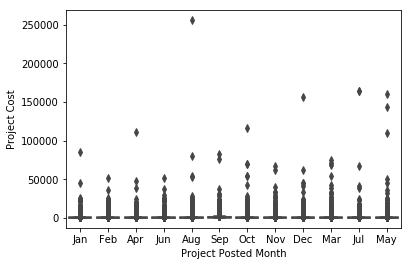

So we can see outliers in Project Cost Skew these results, investigation of those outliers will come later, but for now let is us look at percentiles


In [7]:
sns.boxplot(y='Project Cost',x='Project Posted Month',data=df)
plt.show()
print('So we can see outliers in Project Cost Skew these results, investigation of those outliers will come later, but for now let is us look at percentiles')

In [8]:
df['Project Cost'].quantile([.05,.95])

0.05     182.94
0.95    1977.75
Name: Project Cost, dtype: float64

In [9]:
low = .01
high = .99
df['Project Cost'].quantile([low, high])

0.01     161.920
0.99    2875.683
Name: Project Cost, dtype: float64

In [10]:
outliers = df[df['Project Cost']>df['Project Cost'].quantile(high)].copy(deep=True)

In [11]:
df = df[df['Project Cost']<=3000]

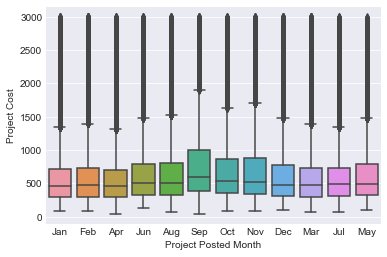

In [22]:
sns.boxplot(y='Project Cost',x='Project Posted Month',data=df)
plt.show()

In [ ]:
temp.sort_index

In [59]:
df['Project Posted Year'].value_counts().sort_index()

2013    123802
2014    154504
2015    171641
2016    234094
2017    248097
2018     78438
Name: Project Posted Year, dtype: int64

******** Distribution of Project Type *********


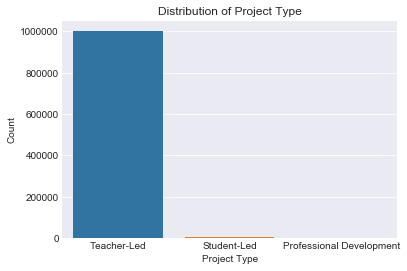

Professional Development       3796
Student-Led                    6400
Teacher-Led                 1000380
Name: Project Type, dtype: int64
 
******** Percent fully funded based on Project Type *********


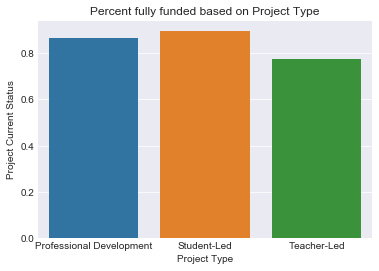

Project Type
Professional Development    0.866175
Student-Led                 0.894375
Teacher-Led                 0.774959
Name: Project Current Status, dtype: float64
 
******** Average Project Cost by Project Type *********


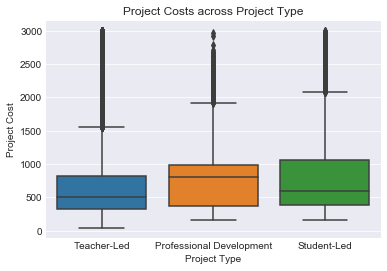

**********************************************************************
******** Distribution of Project Posted Year *********


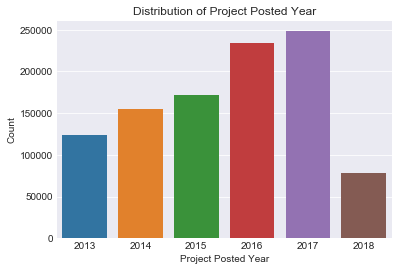

2013    123802
2014    154504
2015    171641
2016    234094
2017    248097
2018     78438
Name: Project Posted Year, dtype: int64
 
******** Percent fully funded based on Project Posted Year *********


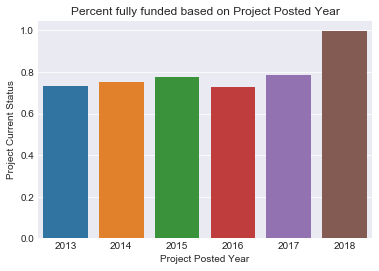

Project Posted Year
2013    0.733978
2014    0.751650
2015    0.778363
2016    0.728968
2017    0.785447
2018    0.996341
Name: Project Current Status, dtype: float64
 
******** Average Project Cost by Project Posted Year *********


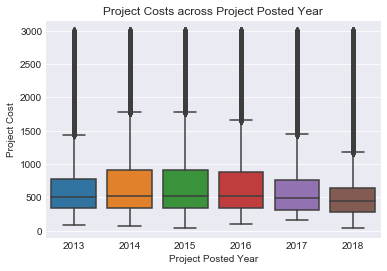

**********************************************************************
******** Distribution of Project Posted Month *********


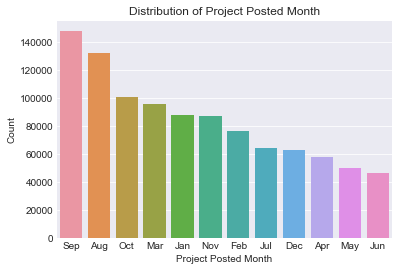

Apr     57959
Aug    132161
Dec     62961
Feb     76762
Jan     87846
Jul     64294
Jun     46415
Mar     95671
May     49849
Nov     87677
Oct    101087
Sep    147894
Name: Project Posted Month, dtype: int64
 
******** Percent fully funded based on Project Posted Month *********


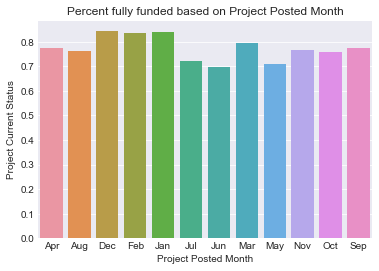

Project Posted Month
Apr    0.774806
Aug    0.760444
Dec    0.842649
Feb    0.835856
Jan    0.838410
Jul    0.722571
Jun    0.696671
Mar    0.793605
May    0.707677
Nov    0.765149
Oct    0.758248
Sep    0.772580
Name: Project Current Status, dtype: float64
 
******** Average Project Cost by Project Posted Month *********


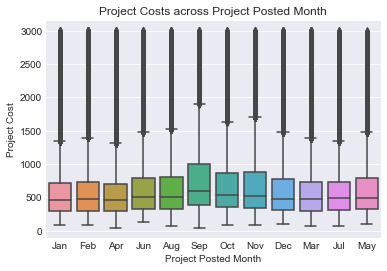

**********************************************************************
******** Distribution of Project Grade Level Category *********


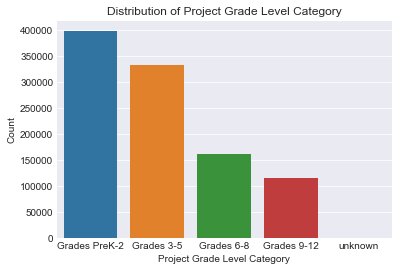

Grades 3-5       333479
Grades 6-8       163103
Grades 9-12      115636
Grades PreK-2    398312
unknown              46
Name: Project Grade Level Category, dtype: int64
 
******** Percent fully funded based on Project Grade Level Category *********


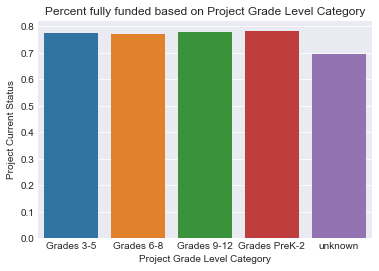

Project Grade Level Category
Grades 3-5       0.772492
Grades 6-8       0.770476
Grades 9-12      0.777889
Grades PreK-2    0.780805
unknown          0.695652
Name: Project Current Status, dtype: float64
 
******** Average Project Cost by Project Grade Level Category *********


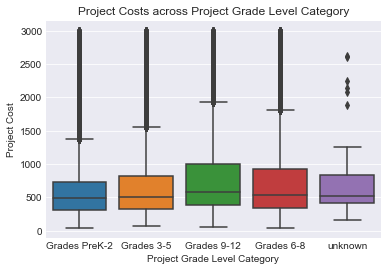

**********************************************************************
******** Distribution of Teacher Prefix *********


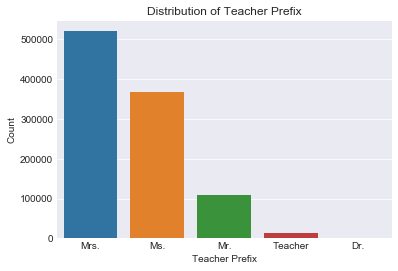

Dr.           258
Mr.        108770
Mrs.       520636
Ms.        367855
Teacher     13057
Name: Teacher Prefix, dtype: int64
 
******** Percent fully funded based on Teacher Prefix *********


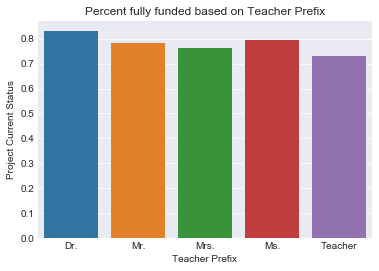

Teacher Prefix
Dr.        0.829457
Mr.        0.782504
Mrs.       0.761981
Ms.        0.795612
Teacher    0.731638
Name: Project Current Status, dtype: float64
 
******** Average Project Cost by Teacher Prefix *********


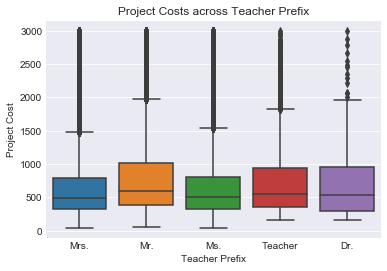

**********************************************************************
******** Distribution of School Metro Type *********


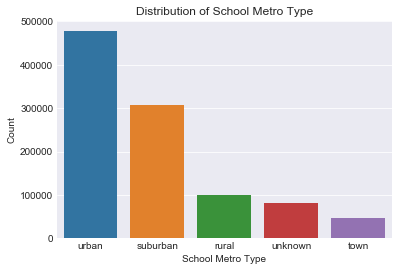

rural        99060
suburban    308149
town         45797
unknown      80224
urban       477346
Name: School Metro Type, dtype: int64
 
******** Percent fully funded based on School Metro Type *********


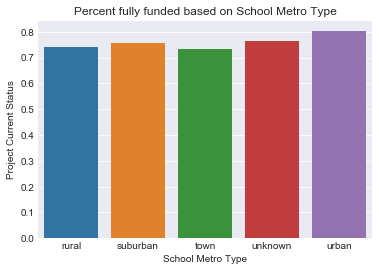

School Metro Type
rural       0.740208
suburban    0.757205
town        0.733170
unknown     0.762365
urban       0.802083
Name: Project Current Status, dtype: float64
 
******** Average Project Cost by School Metro Type *********


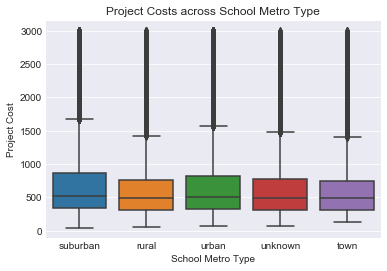

**********************************************************************


In [74]:
for i in ['Project Type', 'Project Posted Year', 'Project Posted Month',
          'Project Grade Level Category','Teacher Prefix','School Metro Type']:
    print("******** Distribution of {} *********".format(i))
    temp = df[i].value_counts().reset_index()
    sns.barplot(x=temp['index'],y=temp[i],data=temp)
    plt.xlabel(i)
    plt.ylabel('Count')
    plt.title('Distribution of {}'.format(i))
    plt.show()
    
    print(df[i].value_counts().sort_index())
    print(' ')
    print("******** Percent fully funded based on {} *********".format(i))
    temp = df.groupby(i)['Project Current Status'].mean().reset_index()
    sns.barplot(temp[i],y=temp['Project Current Status'],data=temp)
    plt.title('Percent fully funded based on {}'.format(i))
    plt.show()
    
    print(df.groupby(i)['Project Current Status'].mean().sort_index())
    print(' ')
    print("******** Average Project Cost by {} *********".format(i))    
    sns.boxplot(x=i,y='Project Cost',data = df)
    plt.title('Project Costs across {}'.format(i))
    plt.show()
    
    print("**********************************************************************")

In [75]:
df.groupby('School State')['Project Current Status'].mean()

School State
Alabama                 0.724535
Alaska                  0.800746
Arizona                 0.725562
Arkansas                0.732243
California              0.774416
Colorado                0.808609
Connecticut             0.827149
Delaware                0.832861
District of Columbia    0.874357
Florida                 0.748733
Georgia                 0.711622
Hawaii                  0.838531
Idaho                   0.794828
Illinois                0.829946
Indiana                 0.789749
Iowa                    0.724729
Kansas                  0.762198
Kentucky                0.741109
Louisiana               0.720924
Maine                   0.808797
Maryland                0.796710
Massachusetts           0.858909
Michigan                0.783946
Minnesota               0.818245
Mississippi             0.698311
Missouri                0.762584
Montana                 0.828678
Nebraska                0.727073
Nevada                  0.695411
New Hampshire           0.8185

### Encode / Scale

In [ ]:
encode_cols = ['Project Type', 'Project Posted Year', 
            'Project Posted Month', 'Project Grade Level Category',
            'Project Resource Category', 'Teacher Prefix',
            'School Metro Type','School State',
            'School District', 'School Zip']

num_cols = ['Project Cost', 'School Percentage Free Lunch',
            'Project num Unique Resources','Total Resource Quantity',
            'Mean Resource Cost', 'Total Project Cost', 'Median Resource Cost',
            'Most exp Resource Cost', 'Least exp Resource Cost']

In [ ]:
#Preprocessing
print('Encoding')

#Encoding
le_dict = {}
if One_Hot:
    df = df.merge(pd.get_dummies(df[encode_cols])
             ,left_index=True,right_index=True)
    for i in encode_cols:
        del df[i]
else:
    for c in encode_cols:
        encod = LabelEncoder()
        encod.fit(df[c].astype(str))
        df[c] = encod.transform(df[c].astype(str))
        le_dict[c] = dict(zip(encod.classes_, encod.transform(encod.classes_)))
    del encod

#Scaling
print('Scaling')

if Standard_Scale:
    Scalar = StandardScaler()
else:
    Scalar = MinMaxScaler()

df[num_cols] = Scalar.fit_transform(df[num_cols])

del One_Hot, LabelEncoder, Standard_Scale, Scalar
gc.collect()

### EDA

In [33]:
le_dict

{'Project Grade Level Category': {'Grades 3-5': 0,
  'Grades 6-8': 1,
  'Grades 9-12': 2,
  'Grades PreK-2': 3,
  'unknown': 4},
 'Project Posted Month': {'Apr': 0,
  'Aug': 1,
  'Dec': 2,
  'Feb': 3,
  'Jan': 4,
  'Jul': 5,
  'Jun': 6,
  'Mar': 7,
  'May': 8,
  'Nov': 9,
  'Oct': 10,
  'Sep': 11},
 'Project Posted Year': {'2013': 0,
  '2014': 1,
  '2015': 2,
  '2016': 3,
  '2017': 4,
  '2018': 5},
 'Project Resource Category': {'Art Supplies': 0,
  'Books': 1,
  'Classroom Basics': 2,
  'Computers & Tablets': 3,
  'Educational Kits & Games': 4,
  'Flexible Seating': 5,
  'Food, Clothing & Hygiene': 6,
  'Instructional Technology': 7,
  'Lab Equipment': 8,
  'Musical Instruments': 9,
  'Other': 10,
  'Reading Nooks, Desks & Storage': 11,
  'Sports & Exercise Equipment': 12,
  'Supplies': 13,
  'Technology': 14,
  'Trips': 15,
  'Visitors': 16},
 'Project Type': {'Professional Development': 0,
  'Student-Led': 1,
  'Teacher-Led': 2},
 'School District': {'A-C Central Cmty Unit Sd 262': 